In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [2]:
#loading CIFAR 10 data

In [3]:
def get_data(train_batch_size=128,test_batch_size=256,Sr=1.0,num_workers=2):

    # Standard transformations (https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-) normalisation matrices taken from here
    x = (0.4914, 0.4822, 0.4465)
    y = (0.2470, 0.2435, 0.2616)
    transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),transforms.Normalize(x,y)])
    transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize(x,y)])

    # Download and create datasets
    X_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    X_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Sample data
    N = int(len(X_train) * Sr)
    X_f,_ = random_split(X_train, [N, len(X_train)-N])

    #Load data
    tr = DataLoader(X_f,batch_size=train_batch_size,shuffle=True, num_workers=num_workers)
    ts = DataLoader(X_test,batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

    return tr, ts

In [4]:

class PatchEmbed(nn.Module):

    def __init__(self,image_size = 32, in_channels=3, patch_size=4, emb_dim=128, stride=None):
        super().__init__()
        self.patch_size = patch_size
        self.image_size = 32
        if stride is None:
            stride = patch_size  # no overlap
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=stride)
        self.linear = nn.Linear(in_channels * patch_size * patch_size, emb_dim)

    def forward(self, x):
        # x: (B, C, H, W)
        patches = self.unfold(x)
        patches = patches.transpose(1, 2)
        embeds = self.linear(patches)  # (B, Num_Patches, emb_dim)
        return embeds


# Pytorch has a module but I wrote it myself because of diff input params i passed
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        E = emb_dim
        self.projections = nn.ModuleList([nn.Linear(E, E) for _ in range(3)])
        self.out = nn.Linear(E, E)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, N, emb_dim) where N=number of patches+1 if CLS token is included
        B, N, _ = x.shape

        # Linear projections
        Q = self.projections[0](x)
        K = self.projections[1](x)
        V = self.projections[2](x)

        # Reshape to multi-head
        Q = Q.reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, N, head_dim)
        K = K.reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        # self attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn = scores.softmax(dim=-1)
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).reshape(B, N, -1)  # (B, N, emb_dim)

        # Final
        out = self.out(out)
        out = self.dropout(out)

        return out, attn

In [5]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        # attention
        self.msa = MultiHeadSelfAttention(emb_dim, num_heads, dropout)
        #layr norms
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        h = int(emb_dim * mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(emb_dim, h),nn.GELU(),nn.Dropout(dropout),nn.Linear(h, emb_dim),nn.Dropout(dropout) )

    def forward(self, x):
        # Attention
        out, attn = self.msa(self.ln1(x))
        x = x + out
        # MLP
        out = self.mlp(self.ln2(x))
        x = x + out

        return x, attn

ViT Model Combined

In [6]:
class VisionTransformer(nn.Module):

    def __init__(self, image_size=32, patch_size=4, stride=None, in_channels=3, emb_dim=128, depth=6, num_heads=4, mlp_ratio=4, num_classes=10, dropout=0.1):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbed(image_size,in_channels, patch_size, emb_dim, stride)

        if stride is None:
            stride = patch_size
        num_h = (image_size - patch_size)//stride + 1
        num_w = (image_size - patch_size)//stride + 1
        self.num_patches = num_h * num_w

        # CLS & posn embeds
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, emb_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.pos_drop = nn.Dropout(p=dropout)

        # Tx block and LN
        self.blocks = nn.ModuleList([TransformerEncoderBlock(emb_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)])
        self.ln = nn.LayerNorm(emb_dim)
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, x, return_attention=False):
        """
        return_attention: if True, returns the attention maps from each block
                          for visualization.
        """
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, emb_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1+Num_Patches, emb_dim)

        # concatening post to x
        x = x + self.pos_embed
        x = self.pos_drop(x)

        attn_maps = []

        # Pass through transformer blocks
        for blk in self.blocks:
            x, attn = blk(x)
            if return_attention:
                attn_maps.append(attn)

        # Classification using the CLS token
        # x = self.ln(x)
        # cls_out = x[:, 0]  # (B, emb_dim)
        # logits = self.fc(cls_out)  # (B, num_classes)

        # if return_attention:
        #     return logits, attn_maps
        # else:
        #     return logits
        logits = self.fc(self.ln(x)[:, 0])  # Final Layer Norm + CLS token for classification
        return (logits, attn_maps) if return_attention else logits

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss,correct,total = 0,0,0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        _, preds = out.max(1)
        correct += preds.eq(y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def test_one_epoch(model, dataloader, criterion):
    model.eval()
    total_loss,correct,total = 0,0,0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            outputs = model(X)
            loss = criterion(outputs, y)

            total_loss += loss.item() * X.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, test_loader, epochs=10, lr=3e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        te_loss, te_acc = test_one_epoch(model, test_loader, criterion)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        test_losses.append(te_loss)
        test_accs.append(te_acc)

        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.2f}% || "
              f"Test Loss: {te_loss:.4f} | Test Acc: {te_acc:.2f}%")

    return train_losses, train_accs, test_losses, test_accs

Experiment 1:

100%|██████████| 170M/170M [00:05<00:00, 29.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[Epoch 1/20] Train Loss: 1.7944 | Train Acc: 32.81% || Test Loss: 1.6514 | Test Acc: 39.64%
[Epoch 2/20] Train Loss: 1.5004 | Train Acc: 44.86% || Test Loss: 1.3701 | Test Acc: 50.16%
[Epoch 3/20] Train Loss: 1.3565 | Train Acc: 50.48% || Test Loss: 1.2560 | Test Acc: 54.49%
[Epoch 4/20] Train Loss: 1.2597 | Train Acc: 54.39% || Test Loss: 1.1853 | Test Acc: 56.85%
[Epoch 5/20] Train Loss: 1.1861 | Train Acc: 57.12% || Test Loss: 1.1208 | Test Acc: 59.17%
[Epoch 6/20] Train Loss: 1.1314 | Train Acc: 59.05% || Test Loss: 1.0701 | Test Acc: 60.91%
[Epoch 7/20] Train Loss: 1.0854 | Train Acc: 61.18% || Test Loss: 1.0159 | Test Acc: 63.47%
[Epoch 8/20] Train Loss: 1.0444 | Train Acc: 62.41% || Test Loss: 0.9791 | Test Acc: 64.96%
[Epoch 9/20] Train Loss: 1.0077 | Train Acc: 63.67% || Test Loss: 0.9512 | Test Acc: 65.01%
[Epoch 10/20] Train Loss: 0.9697 | Train Acc: 65.20% || Test Loss: 0.9168 | Test Ac

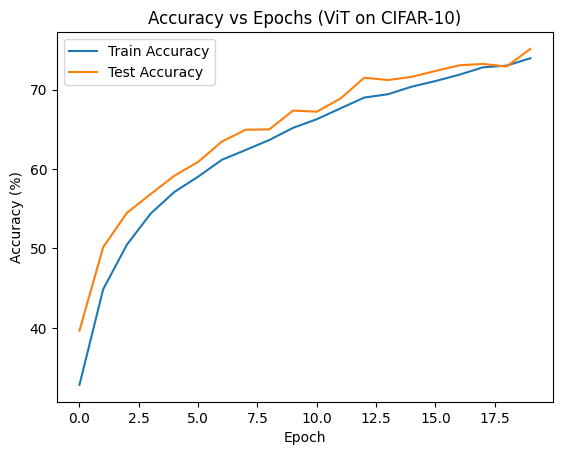

In [8]:
# Example usage
# Load CIFAR-10 dataset (100% training data)
train_loader_full, test_loader_full = get_data(train_batch_size=128, test_batch_size=256, Sr=1.0)

# Initialize Vision Transformer (ViT)
model_vit = VisionTransformer(image_size=32, patch_size=4, stride=4, in_channels=3, emb_dim=128, depth=6, num_heads=4, mlp_ratio=4.0, num_classes=10, dropout=0.1)

# Train the model
train_losses, train_accs, test_losses, test_accs = train_model(model_vit, train_loader_full, test_loader_full, epochs=20, lr=3e-4)


# Plot training curve
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs Epochs (ViT on CIFAR-10)")
plt.show()

In [ ]:
#Plot train and test losses
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, marker="o", linestyle="--", color="green", markersize=6, label="Train Loss")
plt.plot(epochs, test_losses, marker="s", linestyle="-", color="purple", markersize=6, label="Test Loss")

# Formatting the plot
plt.xlabel("Epoch", fontsize=12, fontweight="bold")
plt.ylabel("Loss", fontsize=12, fontweight="bold")
plt.title("Training and Test Loss vs Epochs", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(epochs)

# Show plot
plt.show()

Some visualisations

In [9]:
# CIFAR-10 class labels
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def visualize_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch of images
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # Get predicted class indices

    # Convert images from tensor to numpy and unnormalize
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert (C, H, W) -> (H, W, C)
    images = np.clip(images * 0.25 + 0.5, 0, 1)  # Unnormalize for display

    # Improved Plot Aesthetics
    fig, axes = plt.subplots(2, num_images // 2, figsize=(12, 6))  # 2 rows for better spacing
    fig.suptitle("Vision Transformer Predictions on CIFAR-10", fontsize=14, fontweight="bold")

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        pred_label = class_labels[preds[i]]
        true_label = class_labels[labels[i]]
        title_color = "green" if preds[i] == labels[i] else "red"

        ax.set_title(f"Pred: {pred_label}\nGT: {true_label}", fontsize=10, color=title_color)
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


Experiment 2 : Train your model at different data sizes 5%, 10%, 25%, 50% and 100% of the
training dataset and discuss model performance

In [ ]:
# Define subset sizes and an empty results dictionary
subset_sizes = [0.05, 0.10, 0.25, 0.50, 1.0]  # 5%, 10%, 25%, 50%, 100% of training data
results = {}

for size in subset_sizes:
    print(f"\nTraining on {int(size * 100)}% of CIFAR-10 dataset...")

    train_loader, test_loader = get_data(train_batch_size=128, test_batch_size=256, Sr=size)
    model = VisionTransformer(image_size=32, patch_size=4, stride=4, in_channels=3, emb_dim=128,
                              depth=6, num_heads=4, mlp_ratio=4.0, num_classes=10, dropout=0.1).to(device)

    # Unpack full loss and accuracy arrays for each epoch
    train_losses, train_accs, test_losses, test_accs = train_model(model, train_loader, test_loader, epochs=20, lr=3e-4)

    # For accuracy, we only need the final values;
    # For losses, we store the full arrays (loss curves)
    results[size] = {
        "final_train_acc": train_accs[-1],
        "final_test_acc": test_accs[-1],
        "train_loss": train_losses,
        "test_loss": test_losses
    }


sizes = [int(s * 100) for s in subset_sizes]
train_accs = [results[s]["train_acc"] for s in subset_sizes]
test_accs = [results[s]["test_acc"] for s in subset_sizes]
train_losses = [results[s]["train_loss"] for s in subset_sizes]
test_losses = [results[s]["test_loss"] for s in subset_sizes]

# Figure 1: Accuracy vs. Dataset Size
sizes_plot = [int(s * 100) for s in subset_sizes]
final_train_accs = [results[s]["final_train_acc"] for s in subset_sizes]
final_test_accs = [results[s]["final_test_acc"] for s in subset_sizes]

plt.figure(figsize=(8, 6))
plt.plot(sizes_plot, final_train_accs, marker="o", linestyle="--", color="blue", markersize=8, label="Train Accuracy")
plt.plot(sizes_plot, final_test_accs, marker="s", linestyle="-", color="red", markersize=8, label="Test Accuracy")
plt.xlabel("Percentage of Training Data", fontsize=12, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=12, fontweight="bold")
plt.title("Effect of Training Data Size on ViT Performance", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(sizes_plot)
plt.ylim(30, 80)
plt.show()
# Figure 2: Loss vs. Dataset Size
# Subplot 1: Training Loss Curves
plt.subplot(1, 2, 1)
for size in subset_sizes:
    epochs = range(1, len(results[size]["train_loss"]) + 1)
    plt.plot(epochs, results[size]["train_loss"], marker="o", linestyle="--", label=f"{int(size*100)}%")
plt.xlabel("Epoch", fontsize=12, fontweight="bold")
plt.ylabel("Train Loss", fontsize=12, fontweight="bold")
plt.title("Training Loss vs. Epochs", fontsize=14, fontweight="bold")
plt.legend(title="Training Data %", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Subplot 2: Test Loss Curves
plt.subplot(1, 2, 2)
for size in subset_sizes:
    epochs = range(1, len(results[size]["test_loss"]) + 1)
    plt.plot(epochs, results[size]["test_loss"], marker="s", linestyle="-", label=f"{int(size*100)}%")
plt.xlabel("Epoch", fontsize=12, fontweight="bold")
plt.ylabel("Test Loss", fontsize=12, fontweight="bold")
plt.title("Test Loss vs. Epochs", fontsize=14, fontweight="bold")
plt.legend(title="Training Data %", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


Experiment 4

In [ ]:
# Experiment: Varying Patch Sizes with Overlapping vs Non-Overlapping Conditions
patch_sizes = [4, 8, 12, 16, 32]
overlap_conditions = {"Non-Overlapping": lambda ps: ps, "Overlapping": lambda ps: ps // 2}
results_patch = {}  # Key: (patch_size, condition), Value: final test accuracy

for ps in patch_sizes:
    for condition, stride_fn in overlap_conditions.items():
        stride = stride_fn(ps)
        print(f"\n=== Training with patch_size={ps} | {condition} (stride={stride}) ===")
        model = VisionTransformer(image_size=32, patch_size=ps, stride=stride, in_channels=3, emb_dim=128,
                                  depth=6, num_heads=4, mlp_ratio=4.0, num_classes=10, dropout=0.1).to(device)
        train_loader, test_loader = get_data(Sr=1)  # Using 50% of data for faster result
        _, _, _, test_accs = train_model(model, train_loader, test_loader, epochs=20, lr=3e-4)
        results_patch[(ps, condition)] = test_accs[-1]

# Plotting the results
# Combined Plot
plt.figure(figsize=(8, 6))
for condition in overlap_conditions.keys():
    ps_vals = [ps for ps in patch_sizes]
    acc_vals = [results_patch[(ps, condition)] for ps in patch_sizes]
    plt.plot(ps_vals, acc_vals, marker='o', linestyle='--' if condition == "Non-Overlapping" else '-', label=f"{condition} Patches")

# Formatting
plt.xlabel("Patch Size", fontsize=12, fontweight="bold")
plt.ylabel("Test Accuracy (%)", fontsize=12, fontweight="bold")
plt.title("ViT Performance vs Patch Size (Overlapping vs Non-Overlapping)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(patch_sizes)
plt.ylim(min(results_patch.values()) - 2, max(results_patch.values()) + 2)  # Adjusting Y-axis limits dynamically

plt.show()



=== Training with patch_size=4 | Non-Overlapping (stride=4) ===
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1/20] Train Loss: 1.7847 | Train Acc: 33.30% || Test Loss: 1.6260 | Test Acc: 40.30%
[Epoch 2/20] Train Loss: 1.4867 | Train Acc: 45.64% || Test Loss: 1.4231 | Test Acc: 48.78%
[Epoch 3/20] Train Loss: 1.3399 | Train Acc: 51.43% || Test Loss: 1.2689 | Test Acc: 54.44%
[Epoch 4/20] Train Loss: 1.2437 | Train Acc: 55.01% || Test Loss: 1.1906 | Test Acc: 56.60%
[Epoch 5/20] Train Loss: 1.1839 | Train Acc: 57.42% || Test Loss: 1.1443 | Test Acc: 58.35%
[Epoch 6/20] Train Loss: 1.1219 | Train Acc: 59.41% || Test Loss: 1.0330 | Test Acc: 62.65%
[Epoch 7/20] Train Loss: 1.0770 | Train Acc: 61.06% || Test Loss: 1.0440 | Test Acc: 62.77%


Experiment 4: Varying number of attention heads

In [ ]:
# Experiment: Varying Number of Attention Heads (Plotting Train & Test Accuracies)
num_heads_list = [2, 4, 8]
results_train = {}
results_test = {}

for nh in num_heads_list:
    print(f"\n=== Training with {nh} Attention Heads ===")
    model = VisionTransformer(image_size=32, patch_size=4, stride=4, in_channels=3, emb_dim=128,
                              depth=6, num_heads=nh, mlp_ratio=4.0, num_classes=10, dropout=0.1).to(device)
    train_loader, test_loader = get_data(Sr=1.0)  # Using full training data
    train_losses, train_accs, test_losses, test_accs = train_model(model, train_loader, test_loader, epochs=20, lr=3e-4)
    results_train[nh] = train_accs[-1]
    results_test[nh] = test_accs[-1]

plt.figure()
plt.plot(list(results_train.keys()), list(results_train.values()), marker='o', label='Train Accuracy')
plt.plot(list(results_test.keys()), list(results_test.values()), marker='o', label='Test Accuracy')
plt.xlabel("Number of Attention Heads")
plt.ylabel("Accuracy (%)")
plt.title("ViT Performance vs. Number of Attention Heads")
plt.legend()
plt.show()


Experiment 5

In [ ]:
# Experiment 5: Classify using the CLS token from different model layers via a linear probe

def get_cls_representation(model, x, layer_idx):
    B = x.size(0)
    # Patch embedding and adding CLS token and positional embedding
    x = model.patch_embed(x)
    cls_tokens = model.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + model.pos_embed
    x = model.pos_drop(x)
    # Pass through the first 'layer_idx' transformer blocks
    for i in range(layer_idx):
        x, _ = model.blocks[i](x)
    # Final LayerNorm and extract CLS token
    x = model.ln(x)
    return x[:, 0]  # Shape: (B, emb_dim)

def train_linear_probe(model, train_loader, test_loader, layer_idx, device, epochs=5, lr=1e-3):
    model.eval()
    train_feats, train_labels = [], []
    test_feats, test_labels = [], []
    with torch.no_grad():
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            feats = get_cls_representation(model, imgs, layer_idx)
            train_feats.append(feats.cpu())
            train_labels.append(labels)
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            feats = get_cls_representation(model, imgs, layer_idx)
            test_feats.append(feats.cpu())
            test_labels.append(labels)
    train_feats = torch.cat(train_feats)
    train_labels = torch.cat(train_labels)
    test_feats = torch.cat(test_feats)
    test_labels = torch.cat(test_labels)

    classifier = nn.Linear(train_feats.size(1), 10).to(device)
    optimizer = optim.Adam(classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Train linear classifier (linear probe)
    for epoch in range(epochs):
        classifier.train()
        optimizer.zero_grad()
        outputs = classifier(train_feats.to(device))
        loss = criterion(outputs, train_labels.to(device))
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        outputs = classifier(test_feats.to(device))
        preds = outputs.argmax(dim=1)
        acc = (preds.cpu() == test_labels).float().mean().item() * 100
    return acc

# Evaluate linear probe accuracy from different transformer layers (0 = before blocks, depth = after all blocks)
probe_results = {}
for layer_idx in range(len(model_vit.blocks) + 1):
    acc = train_linear_probe(model_vit, train_loader_full, test_loader_full, layer_idx, device, epochs=5, lr=1e-3)
    probe_results[layer_idx] = acc
    print(f"Layer {layer_idx}: Linear Probe Accuracy = {acc:.2f}%")

# Plot the linear probe accuracy vs. layer index
import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(probe_results.keys()), list(probe_results.values()), marker='o')
plt.xlabel("Layer Index (0 = Before Blocks, Final = After all Blocks)")
plt.ylabel("Linear Probe Accuracy (%)")
plt.title("CLS Token Classification Accuracy vs. Model Layer")
plt.show()


Experiment 6

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention_maps(model, dataloader, device, num_images_per_class=2, num_layers_to_show=None):
    """
    For 2 test images per class, classifies them and visualizes:
    - the original image,
    - and the average CLS token attention map from each transformer block.
    """
    model.eval()
    # Collect 2 images per class from the test loader
    images_per_class = {i: [] for i in range(10)}
    with torch.no_grad():
        for imgs, labels in dataloader:
            for img, label in zip(imgs, labels):
                lbl = label.item()
                if len(images_per_class[lbl]) < num_images_per_class:
                    images_per_class[lbl].append(img)
            if all(len(images_per_class[i]) >= num_images_per_class for i in range(10)):
                break

    # Flatten selected images with their ground truth labels
    selected = []
    for cls in range(10):
        for img in images_per_class[cls]:
            selected.append((img, cls))

    # Process each selected image
    for idx, (img, gt) in enumerate(selected):
        img_batch = img.unsqueeze(0).to(device)  # Shape: (1, C, H, W)
        logits, attn_maps = model(img_batch, return_attention=True)
        pred = logits.argmax(dim=1).item()

        # Determine how many layers to show
        num_layers = len(attn_maps)
        if num_layers_to_show is None:
            num_layers_to_show = num_layers

        # Set up subplots: 1 for original image, plus one per layer to show CLS token attention
        fig, axes = plt.subplots(1, num_layers_to_show + 1, figsize=(3 * (num_layers_to_show + 1), 3))

        # Plot the original image
        # Convert from (C, H, W) to (H, W, C)
        orig_img = img.cpu().numpy().transpose(1, 2, 0)
        # Optionally, unnormalize if needed; here we assume the image is in [0,1]
        axes[0].imshow(np.clip(orig_img, 0, 1))
        axes[0].set_title(f"Orig\nGT: {gt}\nPred: {pred}")
        axes[0].axis("off")

        # For each transformer block, compute and plot the average attention from the CLS token
        for i in range(num_layers_to_show):
            # Each attn map: shape (1, num_heads, seq_len, seq_len)
            attn = attn_maps[i].squeeze(0)  # Now shape: (num_heads, seq_len, seq_len)
            attn_avg = attn.mean(dim=0)      # Average over heads → shape: (seq_len, seq_len)
            # The CLS token is at index 0; skip it for patch-level attention visualization.
            # Compute grid size from number of patches: seq_len = 1 + num_patches, so grid = sqrt(num_patches)
            num_patches = attn_avg.shape[0] - 1
            grid_size = int(np.sqrt(num_patches))
            # Extract attention from the CLS token to the patch tokens and reshape to grid
            cls_attn = attn_avg[0, 1:].reshape(grid_size, grid_size)
            im = axes[i+1].imshow(cls_attn.cpu().numpy(), cmap="viridis")
            axes[i+1].set_title(f"Layer {i+1}\nCLS Attn")
            axes[i+1].axis("off")
            fig.colorbar(im, ax=axes[i+1], fraction=0.046, pad=0.04)

        plt.suptitle(f"Test Image {idx+1} | GT: {gt} | Pred: {pred}", fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Run visualization: take 2 test images per class from test_loader_full, and visualize attention maps
visualize_attention_maps(model_vit, test_loader_full, device, num_images_per_class=2)
